In [45]:
import pandas as pd 
import quandl
import math, datetime
import numpy as np
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import style
import pickle

style.use('ggplot')

In [46]:
df = quandl.get('WIKI/GOOGL') 
df = df[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']]
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Close']) / df['Adj. Close'] * 100.0
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Close'] * 100.0
df = df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume']]
print(len(df))

3424


In [47]:
forecast_col = 'Adj. Close'
df.fillna(-99999, inplace=True)
forecast_out = int(math.ceil(0.01*len(df)))
df['label'] = df[forecast_col].shift(-forecast_out)




X = np.array(df.drop(['label'], 1))
X = preprocessing.scale(X)
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

In [48]:
df.dropna(inplace=True)
y = np.array(df['label'])
print(len(X),len(y))

3389 3389


In [49]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)

#linear regression
clf = LinearRegression()
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)
print(accuracy)

0.9793905619203077


In [50]:
#saving the training in a pickle file
with open('linearRegression.pickle', 'wb') as f:
    pickle.dump(clf,f)
    

In [51]:
#loading the training
pickle_in = open('linearRegression.pickle', 'rb')
clf = pickle.load(pickle_in)

accuracy = clf.score(X_test, y_test)
print(accuracy)

0.9793905619203077


In [52]:
forecast_set = clf.predict(X_lately)
print(forecast_set, accuracy, forecast_out)
df['Forecast'] = np.nan

[1099.85364774 1072.93197471 1020.53406201 1059.85226081 1072.6602067
 1072.65011997 1090.80288071 1110.47053426 1113.72302184 1121.39452132
 1130.76023387 1128.89078688 1147.84699869 1163.42150395 1136.14390997
 1122.13007959 1088.51609782 1101.67284242 1112.92210153 1120.6741685
 1133.66395326 1148.73875979 1179.96848019 1185.00024084 1157.75731459
 1167.82915175 1169.69799505 1153.24707834 1118.59214584 1114.54048685
 1112.00817915 1070.24507537 1042.19201598 1072.4135249  1022.23627626] 0.9793905619203077 35


In [53]:
last_date = df.iloc[-1].name # gets the date of the last
print(last_date)
last_unix = last_date.timestamp() #seconds between 1970 and the lastdate
print(last_unix)
one_day = 86400 # seconds in one day
next_unix = last_unix + one_day
#print(next_unix)

2018-02-05 00:00:00
1517788800.0


In [54]:
for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)# the date after 1970 + next_unix seconds
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)] + [i] #insert the new date as index and NaN for all features except forecast and there inserts the prediccion of the last 35 days

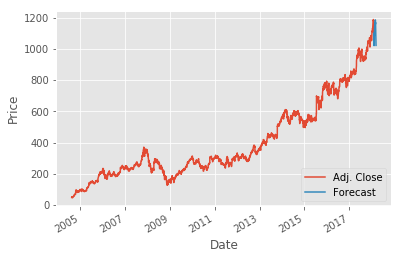

In [55]:
#'Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume'
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()